In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import random
from sklearn.preprocessing import MinMaxScaler


from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

## Loading the data

In [2]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df.tail()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


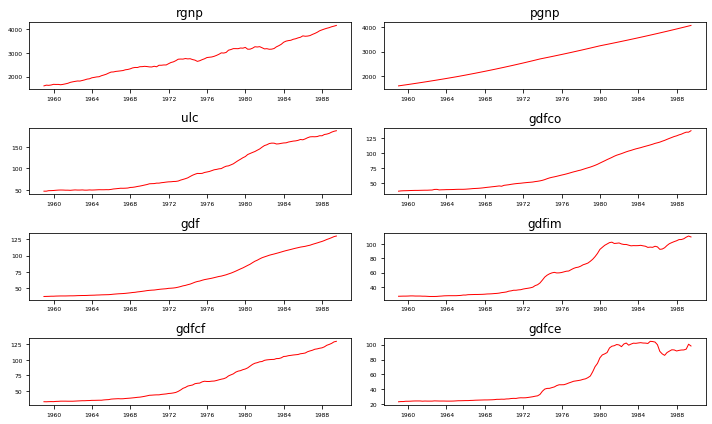

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.tick_params(labelsize=6)
plt.tight_layout()

## AR model
#### checking if data is stationary and other stat tests

{'test_statistic': 0.6419, 'pvalue': 0.9886, 'n_lags': 2, 'n_obs': 120}
P-value:  0.9886
{'test_statistic': -5.4276, 'pvalue': 0.0, 'n_lags': 1, 'n_obs': 120}


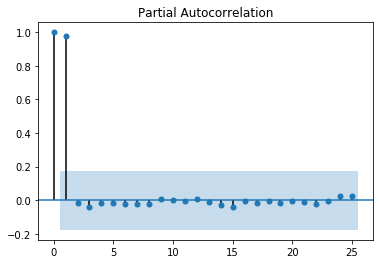

In [4]:
r = adfuller(df['rgnp'], autolag='AIC')
output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
p_value = output['pvalue'] 
print(output)
print("P-value: ", p_value)

v = df.rgnp.values
dv = np.diff(v)
r = adfuller(dv, autolag='AIC')
output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
p_value = output['pvalue'] 
print(output)


pacf = plot_pacf(df['rgnp'], lags=25)

### we see that the data is not stationary so we will use the difference transform with 1 lag acccording to the adfuller test

In [5]:
df_diff = df.diff().dropna()
df_diff.tail()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,32.0,23.8,0.9,1.2,1.6,0.1,2.5,0.5
1988-10-01,26.7,23.9,1.7,1.8,1.3,1.1,1.4,0.1
1989-01-01,37.4,24.1,2.8,1.5,1.5,2.2,1.7,1.1
1989-04-01,25.7,24.2,2.0,0.0,1.6,1.6,2.4,6.6
1989-07-01,30.4,24.3,1.3,2.4,0.9,-1.3,0.9,-2.4


{'test_statistic': -5.4276, 'pvalue': 0.0, 'n_lags': 1, 'n_obs': 120}
P-value:  0.0


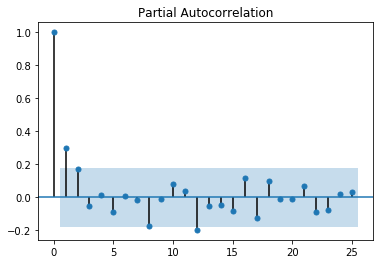

In [6]:
r = adfuller(df_diff['rgnp'], autolag='AIC')
output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
p_value = output['pvalue'] 
print(output)
print("P-value: ", p_value)

pacf = plot_pacf(df_diff['rgnp'], lags=25)

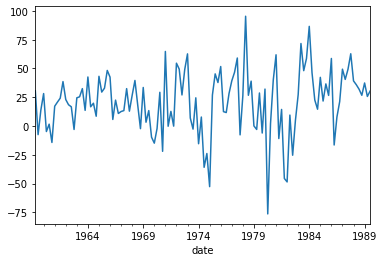

In [7]:
df_diff['rgnp'].plot()


### now the data is stationary and we can use the AR model

In [8]:
### split the data to train and test
train_data = np.asarray(df_diff['rgnp'][:len(df_diff)-10])
test_data = np.asarray(df_diff['rgnp'][len(df_diff)-10:])

In [9]:
lags=2
model = AutoReg(train_data, lags=lags)
model_fit = model.fit()
coef = model_fit.params
print('Coefficients: %s' % coef)

Coefficients: [12.32232121  0.2303992   0.14956776]


predicted=26.874, expected=40.5
predicted=29.042, expected=49.300
predicted=29.738, expected=62.799
predicted=34.165, expected=39.200
predicted=30.746, expected=35.899
predicted=26.456, expected=32.0
predicted=25.064, expected=26.700
predicted=23.260, expected=37.400
predicted=24.932, expected=25.699
predicted=23.837, expected=30.399
Test RMSE: 14.206


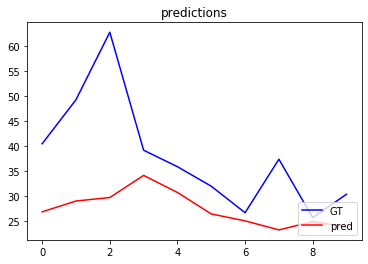

In [10]:
#test model on test data
history = [p for p in train_data[len(train_data)-lags:]]#saving the history from trainig data fr future predictions
predictions = []
for t in range(len(test_data)):
    length = len(history)
    lag = [history[i] for i in range(length-lags,length)]
    yhat = coef[0]
    for d in range(lags):
        yhat += coef[d+1] * lag[lags-d-1]
    obs = test_data[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted={}, expected={}'.format(str(yhat)[:6], str(obs)[:6]))
    
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(test_data, color='blue')
plt.plot(predictions, color='red')
plt.legend(["GT", "pred"], loc ="lower right")
plt.title('predictions')
plt.show()

## VAR model
#### checking if data is good for VAR model

In [11]:
test = 'ssr_chi2test'
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if i!=j:
            test_result = grangercausalitytests(df[[df.columns[i], df.columns[j]]], maxlag=10, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(10)]
            min_p_value = np.min(p_values)
            print(df.columns[i]+' '+df.columns[j]+' : '+str(min_p_value)+' '+str(min_p_value<0.05))

rgnp pgnp : 0.0106 True
rgnp ulc : 0.0001 True
rgnp gdfco : 0.0212 True
rgnp gdf : 0.0027 True
rgnp gdfim : 0.0668 False
rgnp gdfcf : 0.0001 True
rgnp gdfce : 0.0071 True
pgnp rgnp : 0.0 True
pgnp ulc : 0.0 True
pgnp gdfco : 0.0 True
pgnp gdf : 0.0 True
pgnp gdfim : 0.0 True
pgnp gdfcf : 0.0 True
pgnp gdfce : 0.0 True
ulc rgnp : 0.0 True
ulc pgnp : 0.0 True
ulc gdfco : 0.0002 True
ulc gdf : 0.0 True
ulc gdfim : 0.0 True
ulc gdfcf : 0.0 True
ulc gdfce : 0.0041 True
gdfco rgnp : 0.0 True
gdfco pgnp : 0.0 True
gdfco ulc : 0.0 True
gdfco gdf : 0.0 True
gdfco gdfim : 0.0 True
gdfco gdfcf : 0.0 True
gdfco gdfce : 0.0 True
gdf rgnp : 0.0 True
gdf pgnp : 0.0 True
gdf ulc : 0.0 True
gdf gdfco : 0.0 True
gdf gdfim : 0.0 True
gdf gdfcf : 0.0 True
gdf gdfce : 0.0 True
gdfim rgnp : 0.0011 True
gdfim pgnp : 0.0067 True
gdfim ulc : 0.0014 True
gdfim gdfco : 0.0083 True
gdfim gdf : 0.0011 True
gdfim gdfcf : 0.001 True
gdfim gdfce : 0.0 True
gdfcf rgnp : 0.0 True
gdfcf pgnp : 0.0 True
gdfcf ulc : 0.000

### checking if the data is stationary

In [12]:
print('adfuller test for the data')
for col_name in df.columns:
    print(col_name)
    r = adfuller(df[col_name], autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    print(output)
    print("P-value: ", p_value)
    
##not stationary
    
print()
print('adfuller test for the diff data')
for col_name in df_diff.columns:
    print(col_name)
    r = adfuller(df_diff[col_name], autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    print(output)
    print("P-value: ", p_value)
    
##still not stationary
    
df_diff2 = df_diff.diff().dropna()
print()
print('adfuller test for the diff on the diff data')
for col_name in df_diff2.columns:
    print(col_name)
    r = adfuller(df_diff2[col_name], autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    print(output)
    print("P-value: ", p_value)

##now its good

adfuller test for the data
rgnp
{'test_statistic': 0.6419, 'pvalue': 0.9886, 'n_lags': 2, 'n_obs': 120}
P-value:  0.9886
pgnp
{'test_statistic': 1.2743, 'pvalue': 0.9965, 'n_lags': 1, 'n_obs': 121}
P-value:  0.9965
ulc
{'test_statistic': 1.3967, 'pvalue': 0.9971, 'n_lags': 2, 'n_obs': 120}
P-value:  0.9971
gdfco
{'test_statistic': 0.5762, 'pvalue': 0.987, 'n_lags': 5, 'n_obs': 117}
P-value:  0.987
gdf
{'test_statistic': 1.1129, 'pvalue': 0.9953, 'n_lags': 7, 'n_obs': 115}
P-value:  0.9953
gdfim
{'test_statistic': -0.1987, 'pvalue': 0.9387, 'n_lags': 1, 'n_obs': 121}
P-value:  0.9387
gdfcf
{'test_statistic': 1.6693, 'pvalue': 0.9981, 'n_lags': 9, 'n_obs': 113}
P-value:  0.9981
gdfce
{'test_statistic': -0.8159, 'pvalue': 0.8144, 'n_lags': 13, 'n_obs': 109}
P-value:  0.8144

adfuller test for the diff data
rgnp
{'test_statistic': -5.4276, 'pvalue': 0.0, 'n_lags': 1, 'n_obs': 120}
P-value:  0.0
pgnp
{'test_statistic': -1.759, 'pvalue': 0.401, 'n_lags': 0, 'n_obs': 121}
P-value:  0.401
ulc


### tha data looks good so we can use the VAR model

In [13]:
df_train = df_diff2[0:-10]
df_test = df_diff2[-10:]
print(df_train.shape)
print(df_test.shape) 

(111, 8)
(10, 8)


In [14]:
model = VAR(df_train)
x = model.select_order(maxlags=10)
x.summary()

## we will choose lag=3

C:\Users\talit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,-0.3429,-0.1358*,0.7097,-0.2590
1,-0.8891,0.9751,0.4126,-0.1345
2,-1.224,2.297,0.3018,0.2017
3,-1.495,3.684,0.2440,0.6017
4,-1.723,5.113,0.2179,1.045
5,-1.558,6.934,0.3130,1.880
6,-2.412,7.738,0.1828,1.697
7,-3.039,8.768,0.1586,1.741
8,-3.901,9.563,0.1394,1.550
9,-5.722,9.399,0.06917,0.3998


In [15]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 25, Dec, 2021
Time:                     12:45:54
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    2.88232
Nobs:                     108.000    HQIC:                -0.0706914
Log likelihood:          -913.395    FPE:                   0.133157
AIC:                     -2.08459    Det(Omega_mle):       0.0251733
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.226251         2.655675            0.838           0.402
L1.rgnp         -0.771244         0.140779           -5.478           0.000
L1.pgnp          1.229664         4.966003            0.248           0.804
L1.ul

In [16]:
lag = model_fitted.k_ar

history = df_diff2.values[-lag:]

fc = model_fitted.forecast(y=history, steps=10)
df_forecast = pd.DataFrame(fc, index=df.index[-10:], columns=df.columns + '_pred')
df_forecast

,rgnp_pred,pgnp_pred,ulc_pred,gdfco_pred,gdf_pred,gdfim_pred,gdfcf_pred,gdfce_pred
date,,,,,,,,
1987-04-01,17.376132,0.484916,-0.222639,-0.964428,0.589576,-0.394204,1.235903,1.018233
1987-07-01,31.396117,0.394146,-0.524935,-0.667643,-0.548806,2.314554,-0.084304,2.404565
1987-10-01,-55.167026,-0.141369,0.724899,0.147073,-0.065259,-1.648670,-0.789028,-2.169385
1988-01-01,58.513425,0.567602,0.100749,0.563663,0.239273,0.008605,0.551512,0.760535
1988-04-01,-43.900284,-0.081924,0.328657,-0.325049,0.090633,1.134821,0.293410,0.276895
1988-07-01,22.387302,0.549101,-0.604415,-0.023653,-0.214851,-0.018321,-0.346749,-0.253241
1988-10-01,-28.466768,-0.307845,0.334815,0.093750,0.110313,-0.570528,-0.105428,0.042867
1989-01-01,21.803147,-0.099894,0.036740,0.124601,0.045485,0.477885,0.479508,0.619495
1989-04-01,-7.361517,0.101500,0.018547,-0.096870,-0.001966,0.189919,-0.218470,-0.629995


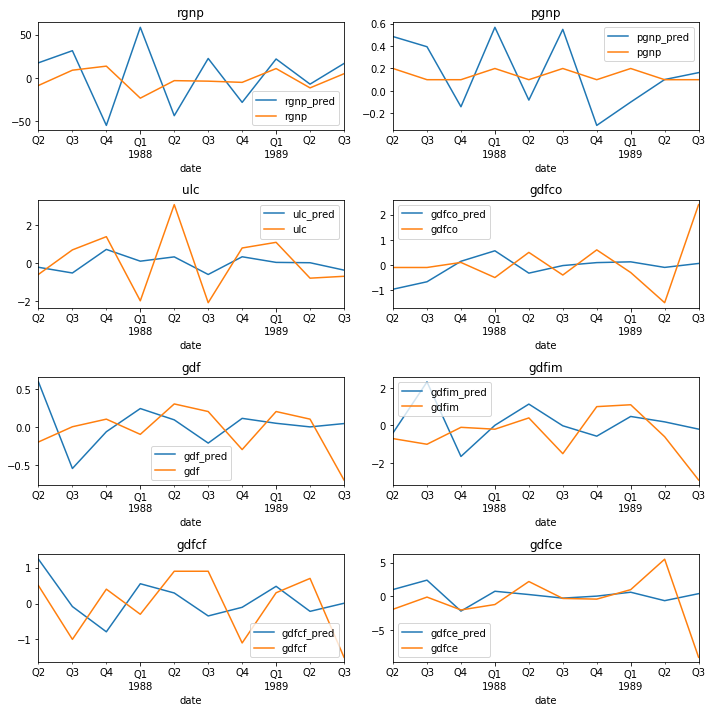

In [17]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col+'_pred'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col)

plt.tight_layout();

In [18]:
for col_name in df_diff2.columns:
    print(col_name)
    rmse = sqrt(mean_squared_error(df_test[col_name][-10:], df_forecast[col_name+'_pred']))
    print('Test RMSE: %.3f' % rmse)

rgnp
Test RMSE: 39.772
pgnp
Test RMSE: 0.279
ulc
Test RMSE: 1.362
gdfco
Test RMSE: 1.044
gdf
Test RMSE: 0.451
gdfim
Test RMSE: 1.645
gdfcf
Test RMSE: 0.979
gdfce
Test RMSE: 3.857


## LSTMs
### for AR model

In [92]:
window=2
BATCH_SIZE=1

def create_data_for_lstm(data,window):
    X=[]
    Y=[]
    for i in range(len(data)-window):
        X.append(np.asarray(data[i:i+window]).reshape((window,1)))
        Y.append(data[i+window])
    return np.asarray(X),np.asarray(Y)

scaler = MinMaxScaler()
data = scaler.fit_transform(np.asarray(df_diff['rgnp']).reshape(-1, 1))

X, Y = create_data_for_lstm(data,window)
len_data = len(X)
X_train_val = X[:-10]
Y_train_val = Y[:-10]
X_test = X[-10:]
Y_test = Y[-10:]

X_train = X_train_val[:int(0.8*len(X_train_val))]
Y_train = Y_train_val[:int(0.8*len(X_train_val))]
X_val = X_train_val[int(0.8*len(X_train_val)):]
Y_val = Y_train_val[int(0.8*len(X_train_val)):]


print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(88, 2, 1) (88, 1)
(22, 2, 1) (22, 1)
(10, 2, 1) (10, 1)


In [93]:
train_dataset = TensorDataset(torch.from_numpy(X_train).float(),torch.from_numpy(Y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(),torch.from_numpy(Y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(),torch.from_numpy(Y_test).float())

train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=False)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

datatloaders={'train':train_dataloader,'val':val_dataloader,'test':test_dataloader}

In [94]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        

        return out
    

In [95]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [99]:
NUM_EPOCHS=2000


input_dim=1
hidden_dims=[2,4,8,16,32]
layer_dim=2
output_dim=1
history_rgnp={}

for hid_dim in hidden_dims:
    lstm_model = LSTMModel(input_dim,hid_dim,layer_dim,output_dim)
    print('\nHidden dim size: ',hid_dim)
#     print(lstm_model)
    print('Number of parameters for LSTM model: '+str(count_parameters(lstm_model)))

    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm_model.parameters())

    best_val_loss=100000000.0
    dest_path_best_model='LSTM_best_model_hd_'+str(hid_dim)+'.pth'

    history_rgnp[hid_dim]={'train_loss':[],'val_loss':[]}

    num_batches=len(train_dataloader)
    for epoch in range(NUM_EPOCHS):  
        
        for phase in ['train','val']:
            if phase=='train':
                lstm_model.train()
            else:
                lstm_model.eval()
            running_loss = 0.0
            running_acc = 0.0
            samples=0
            for i, data_btch in enumerate(datatloaders[phase]):
                inputs, labels = data_btch
                inputs = inputs.view([BATCH_SIZE, -1, input_dim])
                optimizer.zero_grad()
                outputs = lstm_model(inputs)
                loss = criterion(outputs, labels)

                if phase=='train':
                    loss.backward()
                    optimizer.step()

                samples += labels.size(0)
                running_loss += loss.item()*labels.size(0)

#                 if phase=='train':
#                     if i%50==0:
#                         print('Batch {}/{}: loss: {}'.format(str(i),str(num_batches),str(running_loss/samples)[:6]))
            epoch_loss = float(running_loss)/samples
            history_rgnp[hid_dim][phase+'_loss'].append(epoch_loss)
            if epoch%100==0:
                print('Epoch {}:  {} loss: {}'.format(str(epoch),phase,str(epoch_loss)[:6]))
            if phase=='val':
                if epoch_loss<best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(lstm_model,dest_path_best_model)
                


Hidden dim size:  2
Number of parameters for LSTM model: 91
Epoch 0:  train loss: 1.0157
Epoch 0:  val loss: 0.9877
Epoch 100:  train loss: 0.0227
Epoch 100:  val loss: 0.0382
Epoch 200:  train loss: 0.0224
Epoch 200:  val loss: 0.0361
Epoch 300:  train loss: 0.0222
Epoch 300:  val loss: 0.0344
Epoch 400:  train loss: 0.0221
Epoch 400:  val loss: 0.0336
Epoch 500:  train loss: 0.0221
Epoch 500:  val loss: 0.0332
Epoch 600:  train loss: 0.0221
Epoch 600:  val loss: 0.0331
Epoch 700:  train loss: 0.0221
Epoch 700:  val loss: 0.0331
Epoch 800:  train loss: 0.0221
Epoch 800:  val loss: 0.0330
Epoch 900:  train loss: 0.0221
Epoch 900:  val loss: 0.0330
Epoch 1000:  train loss: 0.0221
Epoch 1000:  val loss: 0.0330
Epoch 1100:  train loss: 0.0221
Epoch 1100:  val loss: 0.0330
Epoch 1200:  train loss: 0.0220
Epoch 1200:  val loss: 0.0330
Epoch 1300:  train loss: 0.0220
Epoch 1300:  val loss: 0.0329
Epoch 1400:  train loss: 0.0220
Epoch 1400:  val loss: 0.0329
Epoch 1500:  train loss: 0.0220
E

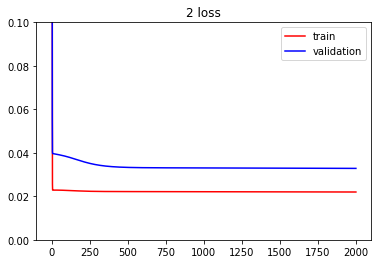

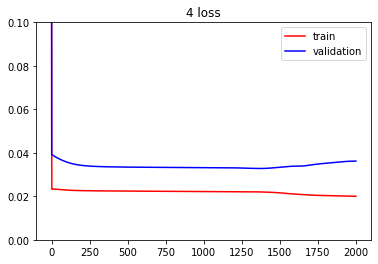

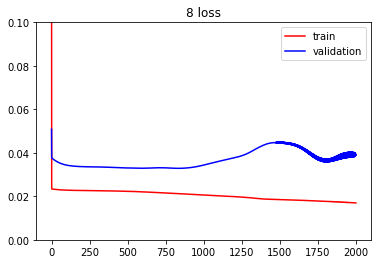

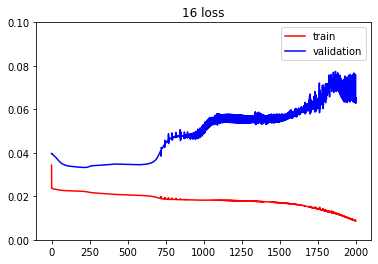

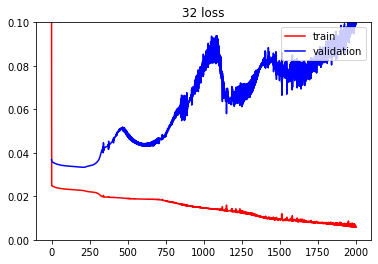

In [100]:
for hid_size,vals in history_rgnp.items():
    plt.plot(vals['train_loss'],c='red')
    plt.plot(vals['val_loss'],c='blue')
    plt.ylim([0.0, 0.1])
    plt.legend(["train", "validation"], loc ="upper right")
    plt.title(str(hid_size)+' loss')
    plt.show()
 

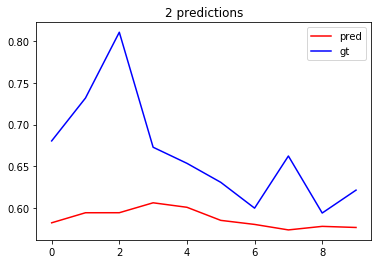

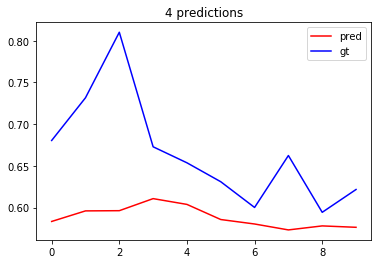

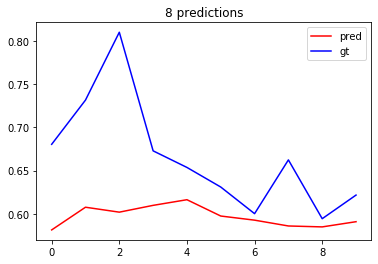

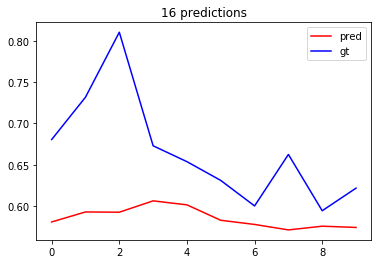

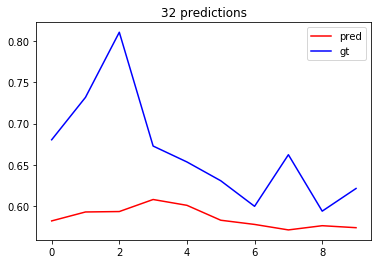

In [107]:
for hid_size in hidden_dims:
    model_path='LSTM_best_model_hd_'+str(hid_size)+'.pth'
    best_lstm_model =torch.load(model_path)
    best_lstm_model.eval()
    predictions=[]
    gt=[]
    with torch.no_grad():
        for i, data_btch in enumerate(datatloaders['test']):
                inputs, labels = data_btch
                outputs = best_lstm_model(inputs)
                for i,out in enumerate(outputs):
                    predictions.append(out)
                    gt.append(labels[i])
    plt.plot(predictions,c='red')
    plt.plot(gt,c='blue')
    plt.legend(["pred", "gt"], loc ="upper right")
    plt.title(str(hid_size)+' predictions')
    plt.show()
            

### for VAR model

In [108]:
window=1
BATCH_SIZE=1

def scale_data(df):
    df_copy = pd.DataFrame().reindex_like(df)
    for col_name in df.columns:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(np.asarray(df[col_name]).reshape(-1, 1))
        df_copy[col_name] = data
    return df_copy

    
def create_data_for_lstm(data,window):
    X=[]
    Y=[]
    for i in range(len(data)-window):
        X.append(np.asarray(data[i:i+window]).reshape((window,8)))
        Y.append(data[i+window])
    return np.asarray(X),np.asarray(Y)

df_copy =scale_data(df_diff2)
X, Y = create_data_for_lstm(np.asarray(df_copy),window)
len_data = len(X)
X_train_val = X[:-10]
Y_train_val = Y[:-10]
X_test = X[-10:]
Y_test = Y[-10:]

X_train = X_train_val[:int(0.8*len(X_train_val))]
Y_train = Y_train_val[:int(0.8*len(X_train_val))]
X_val = X_train_val[int(0.8*len(X_train_val)):]
Y_val = Y_train_val[int(0.8*len(X_train_val)):]


print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(88, 1, 8) (88, 8)
(22, 1, 8) (22, 8)
(10, 1, 8) (10, 8)


In [109]:
train_dataset = TensorDataset(torch.from_numpy(X_train).float(),torch.from_numpy(Y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(),torch.from_numpy(Y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(),torch.from_numpy(Y_test).float())

train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=False)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

datatloaders={'train':train_dataloader,'val':val_dataloader,'test':test_dataloader}

In [110]:
NUM_EPOCHS=2000


input_dim=8
hidden_dims=[2,4,8,16,32]
layer_dim=2
output_dim=8
history_rgnp={}

for hid_dim in hidden_dims:
    lstm_model = LSTMModel(input_dim,hid_dim,layer_dim,output_dim)
    print('\nHidden dim size: ',hid_dim)
    print('Number of parameters for LSTM model: '+str(count_parameters(lstm_model)))

    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm_model.parameters())

    best_val_loss=100000000.0
    dest_path_best_model='LSTM_VAR_best_model_hd_'+str(hid_dim)+'.pth'

    history_rgnp[hid_dim]={'train_loss':[],'val_loss':[]}

    num_batches=len(train_dataloader)
    for epoch in range(NUM_EPOCHS):  
        
        for phase in ['train','val']:
            if phase=='train':
                lstm_model.train()
            else:
                lstm_model.eval()
            running_loss = 0.0
            running_acc = 0.0
            samples=0
            for i, data_btch in enumerate(datatloaders[phase]):
                inputs, labels = data_btch
                inputs = inputs.view([BATCH_SIZE, -1, input_dim])
                optimizer.zero_grad()
                outputs = lstm_model(inputs)
                loss = criterion(outputs, labels)

                if phase=='train':
                    loss.backward()
                    optimizer.step()

                samples += labels.size(0)
                running_loss += loss.item()*labels.size(0)

            epoch_loss = float(running_loss)/samples
            history_rgnp[hid_dim][phase+'_loss'].append(epoch_loss)
            if epoch%100==0:
                print('Epoch {}:  {} loss: {}'.format(str(epoch),phase,str(epoch_loss)[:6]))
            if phase=='val':
                if epoch_loss<best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(lstm_model,dest_path_best_model)
                


Hidden dim size:  2
Number of parameters for LSTM model: 168
Epoch 0:  train loss: 0.3365
Epoch 0:  val loss: 0.2725
Epoch 100:  train loss: 0.0175
Epoch 100:  val loss: 0.0343
Epoch 200:  train loss: 0.0171
Epoch 200:  val loss: 0.0342
Epoch 300:  train loss: 0.0165
Epoch 300:  val loss: 0.0344
Epoch 400:  train loss: 0.0158
Epoch 400:  val loss: 0.0351
Epoch 500:  train loss: 0.0153
Epoch 500:  val loss: 0.0358
Epoch 600:  train loss: 0.0149
Epoch 600:  val loss: 0.0367
Epoch 700:  train loss: 0.0146
Epoch 700:  val loss: 0.0377
Epoch 800:  train loss: 0.0144
Epoch 800:  val loss: 0.0393
Epoch 900:  train loss: 0.0142
Epoch 900:  val loss: 0.0410
Epoch 1000:  train loss: 0.0140
Epoch 1000:  val loss: 0.0428
Epoch 1100:  train loss: 0.0139
Epoch 1100:  val loss: 0.0443
Epoch 1200:  train loss: 0.0138
Epoch 1200:  val loss: 0.0454
Epoch 1300:  train loss: 0.0137
Epoch 1300:  val loss: 0.0462
Epoch 1400:  train loss: 0.0136
Epoch 1400:  val loss: 0.0469
Epoch 1500:  train loss: 0.0136


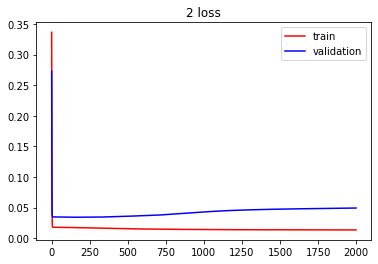

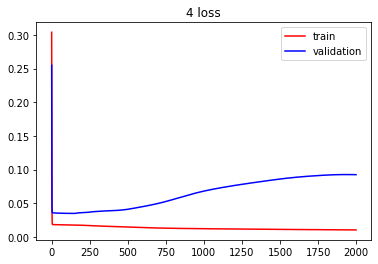

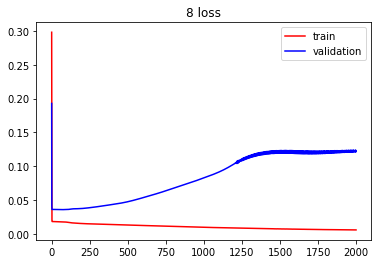

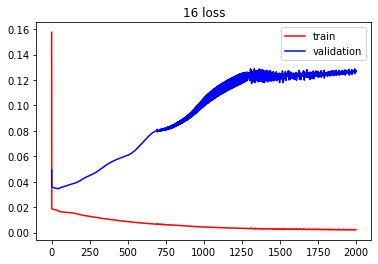

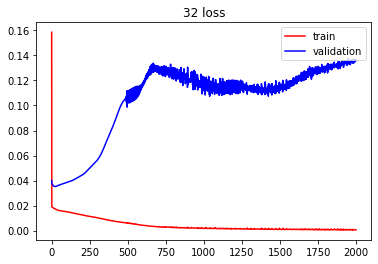

In [112]:
for hid_size,vals in history_rgnp.items():
    plt.plot(vals['train_loss'],c='red')
    plt.plot(vals['val_loss'],c='blue')
    plt.legend(["train", "validation"], loc ="upper right")
    plt.title(str(hid_size)+' loss')
    plt.show()
 

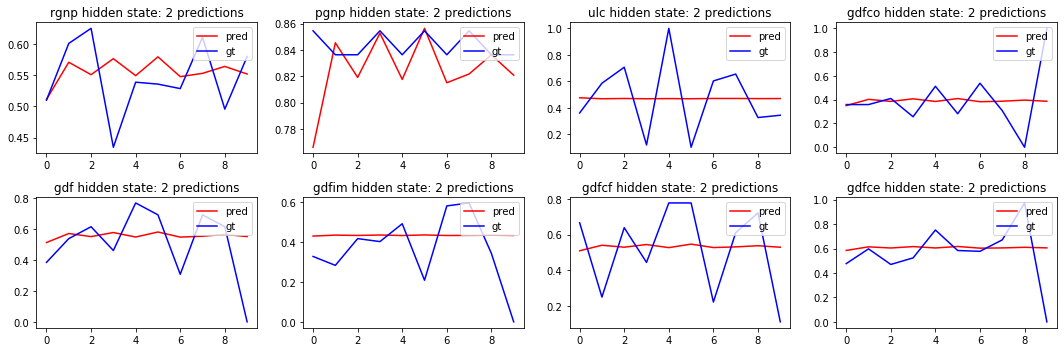

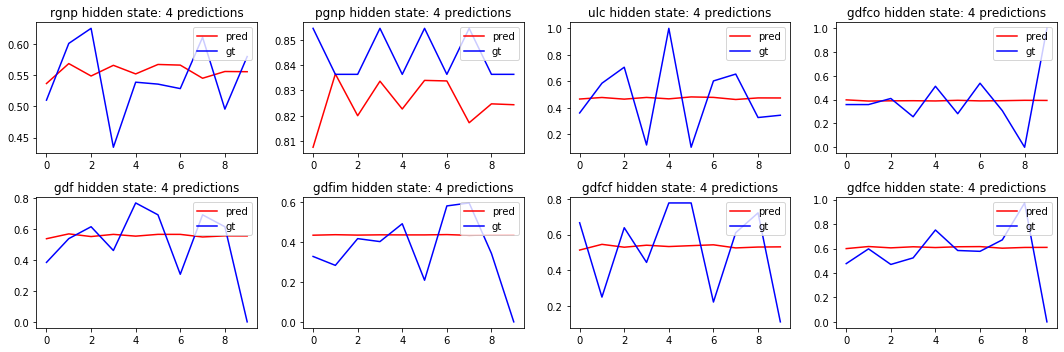

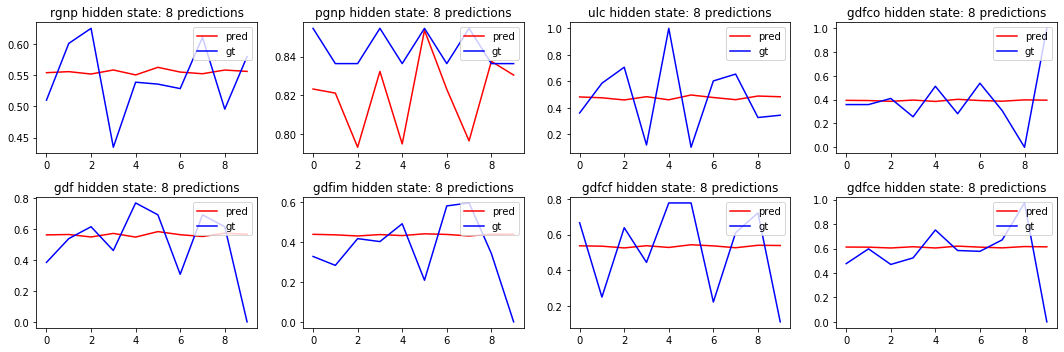

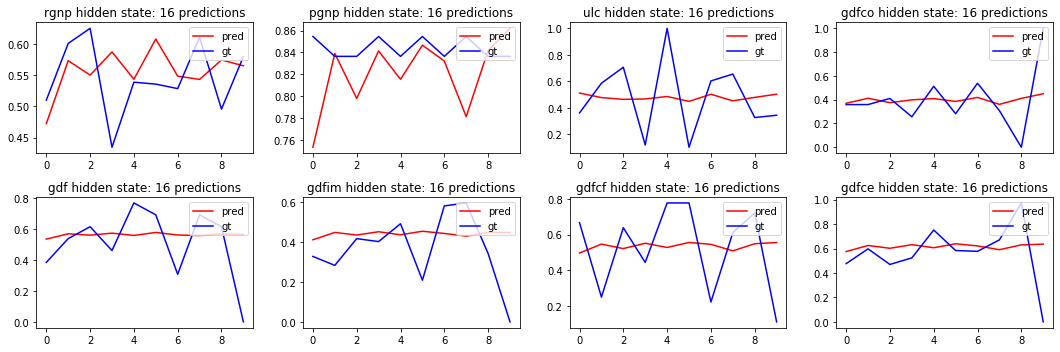

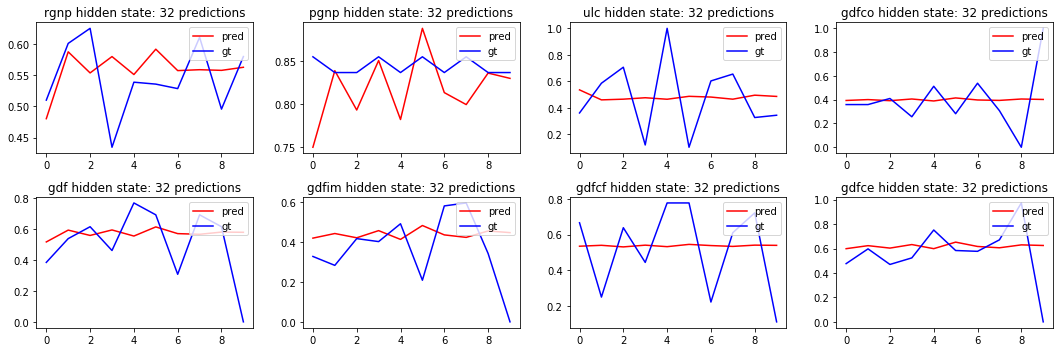

In [114]:
df_columns = df_diff2.columns
for hid_size in hidden_dims:
    model_path='LSTM_VAR_best_model_hd_'+str(hid_size)+'.pth'
    best_lstm_model =torch.load(model_path)
    best_lstm_model.eval()
    predictions=[]
    gt=[]
    with torch.no_grad():
        for i, data_btch in enumerate(datatloaders['test']):
                inputs, labels = data_btch
                outputs = best_lstm_model(inputs)
                for i,out in enumerate(outputs):
                    predictions.append(np.asarray(out))
                    gt.append(np.asarray(labels[i]))
                    
    predictions=np.asarray(predictions)  
    gt=np.asarray(gt)
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
    for i, (col,ax) in enumerate(zip(df_columns, axes.flatten())):
        ax.plot(predictions[:,i],c='red')
        ax.plot(gt[:,i],c='blue')
        ax.legend(["pred", "gt"], loc ="upper right")
        fig_title_ = str(col)+' hidden state: '+str(hid_size)+' predictions'
        ax.set_title(fig_title_)
    plt.tight_layout()

   